In [1]:
#import statements
import os
import os.path
import numpy as np
import time
from subprocess import call
import subprocess
import matplotlib.pyplot as plt

In [2]:
#import blockmesh files 
class block_mesh_modifier:
    def __init__(self,path_to_mesh):
        self.path=path_to_mesh+'/system'
        self.main_path=path_to_mesh
        self.full_path=os.path.join(self.path,'blockMeshDict')
        with open(self.full_path,'r') as f:
            self.lines=f.readlines()
        orig_cell_vals=[]
        for i in self.lines:
            if "hex" in i:
                holder1=i.split(") (")
                cell_nums_str=holder1[1].split(")")[0].split(" ")
                cell_nums_int=[]
                for x in cell_nums_str:
                    cell_nums_int.append(int(x))
                orig_cell_vals.append(cell_nums_int)
        cell_multipliers=np.zeros((len(orig_cell_vals),len(orig_cell_vals[0])))
        for i in range(0,len(orig_cell_vals)):
            for x in range(0,len(orig_cell_vals[0])):
                if orig_cell_vals[i][x]!=1:
                    cell_multipliers[i][x]=float(orig_cell_vals[i][x])
        min_val=0
        for i in range(0,len(cell_multipliers)):
            for x in range(0,3):
                if min_val==0:
                    min_val=cell_multipliers[i][x]
                if min_val>=cell_multipliers[i][x] and cell_multipliers[i][x]>1:
                    min_val=cell_multipliers[i][x]
        cell_multipliers=cell_multipliers/min_val
        self.multipliers=cell_multipliers
        #print(self.multipliers)
        
    def run_sim_prep(self):
        self.control_dict=os.path.join(self.path,'controlDict')
        with open(self.control_dict,'r') as f:
            con_dict_lines=f.readlines()
        time_inter=''
        for i in con_dict_lines:
            if "endTime" in i:
                end_time=i.split(" ")[-1].split(";")[0]
            if "writeInterval" in i and time_inter=='':
                time_inter=float(i.split(" ")[-1].split(";")[0])
            if "string filename" in i:
                results_file=i.split('filename(')[1].split(')')[0].split('"')[1]
        final_file_time=np.floor(float(end_time)/float(time_inter))*float(time_inter)
        if str(final_file_time).split(".")[1]=="0":
            final_file_time=int(final_file_time)
        self.final_time=self.main_path+"/"+str(final_file_time)
        
        #os.system(f"gnome-terminal -e 'bash -c \"cd ..;cd ..;cd {self.path};./Allclean;./Allrun; exit; exec bash\"'")
        #os.system(f"'bash -c \"cd ..;cd ..;cd {self.path};./Allclean;./Allrun; exit; exec bash\"'")
        #run_sim(self.path)
        #start=time.time()
        #end=start
        #while os.path.exists(self.final_time)==False:
         #   end=time.time()
        #runtime=end-start
        
        results_path=os.path.join(self.main_path,results_file)
        self.results=results_path
        #with open(results_path,'r') as f:
         #   results_lines=f.readlines()
        
        #return runtime,results_lines
    
    def block_mesh_export(self,cell_nums):
        cell_num_ind=0
        #print()
        #print(cell_nums)
        #print()
        for i in range(0,len(self.lines)):
            if "hex" in self.lines[i]:
                mod_line=""
                holder1=self.lines[i].split(") (")
                mod_line+=holder1[0]
                mod_line+=") ("+ str(cell_nums[cell_num_ind][0])+ " " +str(cell_nums[cell_num_ind][1])+" " +str(cell_nums[cell_num_ind][2])+")"
                mod_line+=holder1[1].split(")")[1]+")  \n"
                self.lines[i]=mod_line
                cell_num_ind+=1
        with open(self.full_path,'w') as f:
            f.writelines(self.lines)
        
        

In [3]:
def run_convergence_test(bmm,startn,endn,numn,true_val):
    #get the "true" value
    cell_nums=np.ones((len(bmm.multipliers),3),dtype=int)
    #print()
    #print(bmm.multipliers)
    #print()
    for i in range(0,len(bmm.multipliers)):
        for x in range(0,3):
            if bmm.multipliers[i][x]!=0:
                cell_nums[i][x]=int(true_val*bmm.multipliers[i][x])#Here ?
    bmm.block_mesh_export(cell_nums)
    bmm.run_sim_prep()
    start=time.time()
    end=start
    #run_sim(bmm.path)
    process = subprocess.Popen(
        f"gnome-terminal -e 'bash -c \"cd ..;cd ..;cd {bmm.main_path};./Allclean;./Allrun; exit; exec bash\"'", 
        stdout=subprocess.PIPE,
        stderr=None,
        shell=True
    )
    time.sleep(2)
    while os.path.exists(bmm.final_time)==False or start==end:
        end=time.time()
    runtime=end-start
    #print(runtime)
    time.sleep(5)
    with open(bmm.results,'r') as f:
        results_lines=f.readlines()
        times=[0]*len(results_lines)
        res_vals=[0]*len(results_lines)
        for i in range(0,len(results_lines)):
            cur_line=results_lines[i].split(' ')
            times[i]=float(cur_line[0])
            res_vals[i]=float(cur_line[1].split('\n')[0])
    true_times=times
    true_results=res_vals
    true_results=np.array(true_results)
    true_runtime=runtime
    #print(true_runtime)
    #run for array of cell numbers
    base_arr=np.linspace(startn,endn,numn,endpoint=True)
    results=[]
    run_times=[]
    sum_errs=[]
    #print()
    #print(bmm.multipliers)
    for m in base_arr:
        cell_nums=np.ones((len(bmm.multipliers),3),dtype=int)
        #print(bmm.multipliers)
        #print(m)
        #print()
        for i in range(0,len(bmm.multipliers)):
            for x in range(0,3):
                if bmm.multipliers[i][x]!=0:
                    cell_nums[i][x]=int(m*bmm.multipliers[i][x]) ##problem here ?
        #print()
        #print(cell_nums)
        #print()
        bmm.block_mesh_export(cell_nums)
        bmm.run_sim_prep()
        start=time.time()
        end=start
        #run_sim(bmm.path)
        process = subprocess.Popen(
            f"gnome-terminal -e 'bash -c \"cd ..;cd ..;cd {bmm.main_path};./Allclean;./Allrun; exit; exec bash\"'", 
            stdout=subprocess.PIPE,
            stderr=None,
            shell=True
        )
        time.sleep(5)
        while os.path.exists(bmm.final_time)==False or start==end:
            end=time.time()

        #start=time.time()
        #end=start
        #while os.path.exists(bmm.final_time)==False:
        #    end=time.time()
        runtime=end-start
        time.sleep(5)
        with open(bmm.results,'r') as f:
            results_lines=f.readlines()
            times=[0]*len(results_lines)
            res_vals=[0]*len(results_lines)
            for i in range(0,len(results_lines)):
                cur_line=results_lines[i].split(' ')
                times[i]=float(cur_line[0])
                res_vals[i]=float(cur_line[1].split('\n')[0])
        run_times.append(runtime)
        #print(runtime)
        res_vals=np.array(res_vals)
        errors=np.absolute(true_results-res_vals)
        sum_err=sum(errors)
        sum_errs.append(sum_err)
    return sum_errs,base_arr

In [4]:
path_to_cyl_con='/home/clove/rheoTool/of90/custom_models/Cylinder_con/Oldroyd-BLog'
cyl_mesh=block_mesh_modifier(path_to_cyl_con)
errors,base_arr=run_convergence_test(cyl_mesh,1,30,30,40)

# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line t

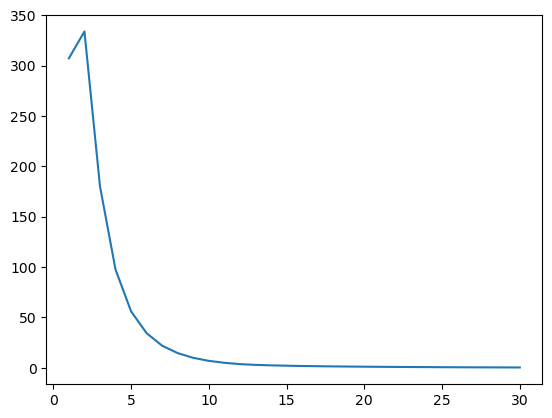

In [5]:
plt.plot(base_arr,errors)

In [ ]:
#try log log plot for power law in convergence

#get convergence program to run on flow past sphere 
    #pinch point could be source of error 

#LRPS - see papers
    #rolie-poly in rheotool 
    #can modify files directly

#run mesh in rolie-poly
    #first try doing this through basic cylinder
    #then implement flow past sphere 
    